In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "../data/raw/synthetic_coffee_health_10000.csv"
MODEL_PATH = "../outputs/models/final_health_risk_model.pkl"

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (10000, 16)


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [ ]:
df.fillna({
    'Gender': df['Gender'].mode()[0],
    'Country': df['Country'].mode()[0],
    'Sleep_Quality': df['Sleep_Quality'].mode()[0],
    'Occupation': df['Occupation'].mode()[0],
    'Smoking': df['Smoking'].mode()[0],
    'Alcohol_Consumption': df['Alcohol_Consumption'].mode()[0]
}, inplace=True)


categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Occupation', 'Smoking', 'Alcohol_Consumption', 'Stress_Level']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

print(df.isnull().sum())


ID                            0
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64


In [ ]:
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0,18.5,24.9,29.9,100], labels=['Underweight','Normal','Overweight','Obese'])
df['BMI_Category'] = LabelEncoder().fit_transform(df['BMI_Category'])

df.drop(['ID'], axis=1, inplace=True, errors='ignore')


In [ ]:

df_model = df.dropna(subset=['Health_Issues']).copy()
X = df_model.drop('Health_Issues', axis=1)
y = df_model['Health_Issues']

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy: 0.9963054187192119

Classification Report:
               precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       716
    Moderate       0.99      0.98      0.98        93
      Severe       1.00      1.00      1.00         3

    accuracy                           1.00       812
   macro avg       1.00      0.99      0.99       812
weighted avg       1.00      1.00      1.00       812



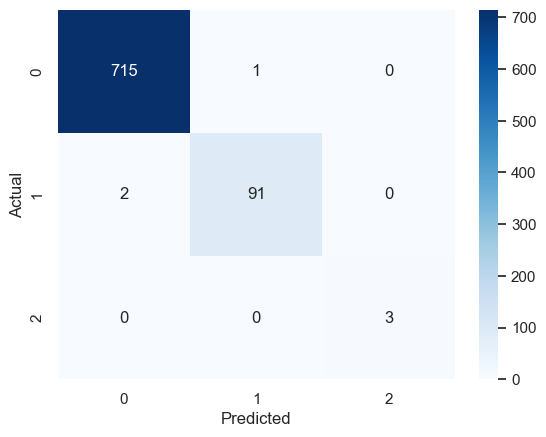

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


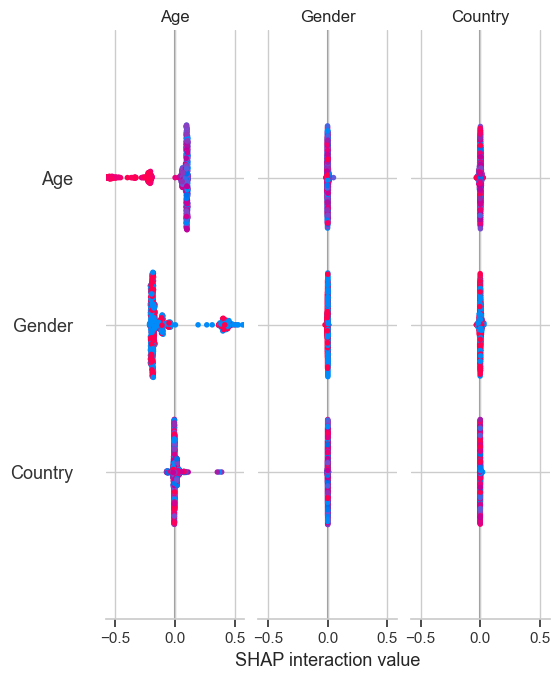

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [ ]:
def predict_health_risk(new_data: pd.DataFrame):
    """
    new_data: DataFrame with same features as training data (excluding target)
    Returns predicted health risk
    """
    
    for col in categorical_cols:
        le = LabelEncoder()
        new_data[col] = le.fit_transform(new_data[col])
    
    new_data['BMI_Category'] = pd.cut(new_data['BMI'], bins=[0,18.5,24.9,29.9,100], labels=[0,1,2,3])
    
    X_new = scaler.transform(new_data)
    return model.predict(X_new)


In [ ]:
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, "../outputs/models/scaler.pkl")
print("Model and scaler saved for deployment.")


Model and scaler saved for deployment.
